# Cosmology project: Measuring Cosmic acceleration with Type Ia Supernovaes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.integrate as pyint
import scipy.constants as const
import scipy.stats as stat
import numpy as np

In [2]:
database_file = 'SCPUnion2.1_AllSNe.txt'
SNe_df = pd.read_csv(database_file,header=None, sep=r'\)?\s+&\s+', engine='python', na_filter = ['\nodata','\nodata\\'],
                    names=['ID', 'z', 'Mb',  'stretch', 'color',
                           'd_mod', 'unknown', 'sample', 'Cuts Failed']).set_index('ID')
SNe_df['Cuts Failed'] = SNe_df['Cuts Failed'].str.slice(stop=-2)
SNe_df.head(10)

,z,Mb,stretch,color,d_mod,unknown,sample,Cuts Failed
ID,,,,,,,,
1993ah,0.0285,16.86(0.19,-2.26(0.93,0.23(0.09,35.35(0.22,0.128,1.0,\nodata
1993ag,0.0500,17.79(0.05,-1.09(0.24,0.12(0.02,36.68(0.17,0.128,1.0,\nodata
1993o,0.0529,17.60(0.05,-1.03(0.14,-0.01(0.02,36.82(0.16,0.128,1.0,\nodata
1993b,0.0701,18.43(0.04,-0.53(0.21,0.09(0.02,37.45(0.16,0.128,1.0,\nodata
1992bs,0.0627,18.25(0.05,-0.27(0.23,0.02(0.02,37.48(0.16,0.128,1.0,\nodata
1992br,0.0876,19.19(0.11,-2.97(0.38,-0.04(0.07,38.23(0.19,0.128,1.0,\nodata
1992bp,0.0786,18.27(0.04,-1.27(0.20,-0.02(0.02,37.49(0.16,0.128,1.0,\nodata
1992bo,0.0172,15.75(0.13,-2.68(0.18,0.03(0.02,34.65(0.20,0.128,1.0,\nodata
1992bl,0.0422,17.30(0.08,-1.95(0.24,0.02(0.04,36.34(0.17,0.128,1.0,\nodata


In [3]:
def split_errors(df,name):
    #print df.loc[df[name]==na][name]
    mask = df[name].str.slice(start=-6)=='nodata'
    df.loc[mask, name] = 'NaN(NaN'
    split_df = df[name].str.split('(',expand=True)
    df[name] = split_df[0].astype(float)
    df['err_{}'.format(name)] = split_df[1].astype(float)
split_errors(SNe_df,'Mb')
split_errors(SNe_df,'stretch')
split_errors(SNe_df,'color')
split_errors(SNe_df,'d_mod')
nice_columns = ['z', 'Mb', 'err_Mb',  'color', 'err_color',
                           'd_mod', 'err_d_mod']
SNe_df = SNe_df[nice_columns]
SNe_df.head()

,z,Mb,err_Mb,color,err_color,d_mod,err_d_mod
ID,,,,,,,
1993ah,0.0285,16.86,0.19,0.23,0.09,35.35,0.22
1993ag,0.0500,17.79,0.05,0.12,0.02,36.68,0.17
1993o,0.0529,17.60,0.05,-0.01,0.02,36.82,0.16
1993b,0.0701,18.43,0.04,0.09,0.02,37.45,0.16
1992bs,0.0627,18.25,0.05,0.02,0.02,37.48,0.16


The fitted parameters are:
	H0=69.5339599448(0.38431218433)
	Om=0.28853943124(0.195593441238)
	Ok=0.00632680763971
	Ode=0.705133761121(0.178658693455)


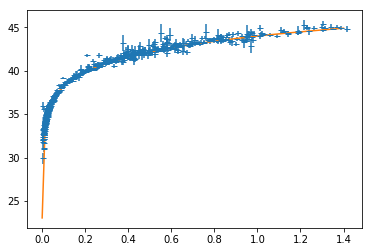

In [4]:
# fit directly with curve fit
def Hz_flatLCDM(z,*args):
    H0,Om,Ode = args
    Ok = 1-Om-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ok*(1+z)**2+Ode)
    return Hz

def chi(zvec,Hz_fun,args):
    chi = const.c/1000*np.array([pyint.quad(lambda zz: 1./Hz_fun(zz,*args),0,z)[0] for z in zvec])
    return chi

def dist_lum(z,Hz_fun,args):
    return chi(z,Hz_fun,args)*(1+z)

def dist_mod(z,Hz_fun,args):
    D_L = dist_lum(z,Hz_fun,args)
    return 5*np.log10(D_L)+25

def fit_d_mod(z,Hz_fun,args):
    return dist_mod(z,Hz_fun,args[:-1])-args[-1]*(1-sum(args))
    
z_grid = np.linspace(1e-4,1.4,100)
mask = np.isfinite(SNe_df['z']) & np.isfinite(SNe_df['d_mod'])
cosmo_params = [73.8,.3,0.7]

res = opt.curve_fit(lambda z,*p: dist_mod(z,Hz_flatLCDM,p),
                    xdata=SNe_df[mask]['z'],
                    ydata=SNe_df[mask]['d_mod'],
                    sigma = SNe_df[mask]['err_d_mod'], absolute_sigma=True,
                    p0=cosmo_params)
res_err = np.sqrt(np.diag(res[1]))
H0,Om,Ode = res[0]
print 'The fitted parameters are:\n\tH0={1}({4})\n\tOm={2}({5})\
\n\tOk={0}\n\tOde={3}({6})'.format(1-sum(res[0][1:]),*np.append(res[0],res_err))
plt.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_')
plt.plot(z_grid,dist_mod(z_grid,Hz_flatLCDM,cosmo_params))

In [5]:
'''
# fith with chi square minimization
def chi2(zdata,dmoddata,dmod_err,Hz_fun,args):
    square = (dmoddata-dist_mod(zdata,Hz_fun,args))**2
    return sum(square/dmod_err**2)

fit_chi2 = lambda cosmo: chi2(SNe_df[mask]['z'],SNe_df[mask]['d_mod'],SNe_df[mask]['err_d_mod'],Hz_flatLCDM,cosmo)
print fit_chi2(cosmo_params)
res = opt.minimize(fit_chi2,
                   x0=cosmo_params)
print res
'''

"\n# fith with chi square minimization\ndef chi2(zdata,dmoddata,dmod_err,Hz_fun,args):\n    square = (dmoddata-dist_mod(zdata,Hz_fun,args))**2\n    return sum(square/dmod_err**2)\n\nfit_chi2 = lambda cosmo: chi2(SNe_df[mask]['z'],SNe_df[mask]['d_mod'],SNe_df[mask]['err_d_mod'],Hz_flatLCDM,cosmo)\nprint fit_chi2(cosmo_params)\nres = opt.minimize(fit_chi2,\n                   x0=cosmo_params)\nprint res\n"

In [6]:
# using equation 3.48 of the cosmology notes
q0 = Om/2-Ode
print 'The deceleration parameter is {}, thus, the expansion of the universe is accelerated'.format(q0)

The deceleration parameter is -0.560864045501, thus, the expansion of the universe is accelerated


17.920597332791996
66.40357366489609 153.49935226910475
18.43037462945379


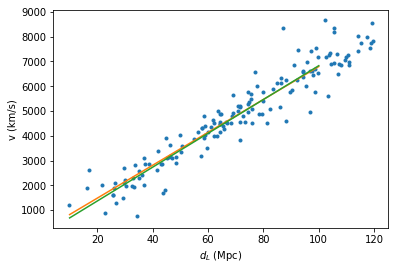

In [7]:
# calculate H0
z_cut = 0.03
H0_mask = (SNe_df['z']<z_cut) & mask
v_SNe = const.c/1000.*SNe_df[H0_mask]['z']
dL_SNe = 10**((SNe_df[H0_mask]['d_mod']-25+2.5*np.log10(1+SNe_df[H0_mask]['z']))/5)
dL_max = 120
v_SNe=v_SNe[dL_SNe<dL_max]
dL_SNe=dL_SNe[dL_SNe<dL_max]
H0_fit, intercept, r, p, err = stat.linregress(dL_SNe,v_SNe)
H0_curvefit = opt.curve_fit(lambda d,H: H*d, dL_SNe, v_SNe, p0=H0)[0][0]
print 1/H0_curvefit*1e6*3.86e13/3.154e7/1e9
print H0_fit,intercept
dL_grid = np.linspace(10,100)
plt.plot(dL_SNe,v_SNe,'.')
plt.plot(dL_grid,dL_grid*H0_fit+intercept)
plt.plot(dL_grid,dL_grid*H0_curvefit)
plt.xlabel('$d_L$ (Mpc)')
plt.ylabel('v (km/s)')
age_universe_Gyr = 1/H0_fit*1e6*3.86e13/3.154e7/1e9
print age_universe_Gyr

In [8]:
# calculate w
def Hz_w_cte(z,*args):
    H0,Om,Ode,w = args
    Ok = 1-Om-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ok*(1+z)**2+Ode*np.exp(3*(1+w)*np.log(1+z)))
    return Hz

res = opt.curve_fit(lambda z,*p: dist_mod(z,Hz_w_cte,p),
                    xdata=SNe_df[mask]['z'],
                    ydata=SNe_df[mask]['d_mod'],
                    sigma = SNe_df[mask]['err_d_mod'], absolute_sigma=True,
                    p0=cosmo_params+[-1])

In [9]:
print res[0],np.sqrt(np.diag(res[1]))

[ 6.96445828e+01  3.65399237e-02  3.22662795e-01 -1.68827573e+00] [0.52011261 0.4822724  0.5129201  2.16229683]
